# Enhancement

## Objective

The main goal is to improve the quality of images in a data set through a series of transformations. This will be carried out in a standardized way, ensuring that all images are processed in the same way. The quality of the enhanced images will then be evaluated using the BRISQUE metric.

### Project Steps

#### 1. Image Enhancement

Enhancements will be applied to all images in the data set. These improvements may include:

- Increased color saturation.
- Focus application to improve sharpness.
- Resizing images for a specific size.

The goal is to improve the visual quality of the images.

#### 2. Standardization of the Data Set

It is essential that all images are processed consistently. This ensures that the data set is standardized and suitable for analysis.

#### 3. Evaluation with BRISQUE

The BRISQUE metric (https://github.com/rehanguha/brisque) will be used to evaluate the quality of the enhanced images. The average BRISQUE value will be calculated over a subset of 50 randomly selected images from the enhanced data set.

#### 4. BRISQUE Score Comparison

The BRISQUE values before and after applying image enhancement will be compared. This will allow us to evaluate whether the transformations have had a positive impact on the quality of the images.

#### 5. Viewing Results

To visualize the results, three images will be shown as examples:

- An image with the best BRISQUE value after enhancement.
- An image with a BRISQUE value close to the average after enhancement.
- The image with the worst quality after the improvement in terms of BRISQUE.

This will allow a visual evaluation of how the transformations have affected the quality of the images in the data set.

This project aims to improve the visual quality of images and quantify that improvement using BRISQUE as an evaluation metric.

## Code solution:

### Library Import:

In [6]:
import os
import random
import shutil
import cv2
from brisque import BRISQUE
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 

### Definition of directories:

In [7]:
carpeta_origen = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\TodosGatosPerrosRenombrados\\TodosGatosPerros'
input_directory = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\pgi'
output_directory = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\pgo'

### Random selection of images:

In [8]:
if not os.path.exists(input_directory):
    os.makedirs(input_directory)

archivos_en_carpeta = os.listdir(carpeta_origen)

imagenes = [archivo for archivo in archivos_en_carpeta if archivo.endswith(('.jpg', '.jpeg', '.png'))]

if len(imagenes) < 50:
    print("There are not enough images in the source folder.")
else:
    
    imagenes_seleccionadas = random.sample(imagenes, 50)

    for i, imagen in enumerate(imagenes_seleccionadas):
        origen = os.path.join(carpeta_origen, imagen)
        destino = os.path.join(input_directory, f'{imagen}')
        shutil.copy(origen, destino)

    print("50 images have been copied and renamed to the destination folder.")

50 images have been copied and renamed to the destination folder.


### Image processing functions:

In [9]:
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

image_files = os.listdir(input_directory)

max_size = 1000

def aumentar_saturacion(imagen, factor_saturacion):
    imagen_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    imagen_hsv[:,:,1] = np.clip(imagen_hsv[:,:,1] * factor_saturacion, 0, 255).astype(np.uint8)
    imagen_vibrante = cv2.cvtColor(imagen_hsv, cv2.COLOR_HSV2BGR)

    return imagen_vibrante

#La imagen se convierte al espacio de color HSV, se escala la saturación en el canal HSV multiplicando por el factor de saturación proporcionado, los valores se limitan para asegurar que estén en el rango válido (0-255) y se convierte de nuevo a BGR.


def unsharp_mask(image, kernel_size=(9, 9), sigma=1, amount=1, threshold=95):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)
    sharpened = np.where(sharpened > threshold, sharpened, image)
    return sharpened

# La imagen se desenfoca utilizando un filtro gaussiano, luego la imagen original se combina con la versión desenfocada ponderando las diferencias y se aplica un umbral para controlar qué áreas de la imagen se mejoran.

def enhance_and_resize_image(image):
    if image is not None:

        yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))

        yuv_image[:,:,0] = clahe.apply(yuv_image[:,:,0])
        enhanced_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR) 
        

        height, width = enhanced_image.shape[:2]
        if height > width:
            new_height = max_size
            new_width = int(width * (max_size / height))
        else:
            new_width = max_size
            new_height = int(height * (max_size / width))

        
        resized_image = cv2.resize(enhanced_image, (new_width, new_height), interpolation=cv2.INTER_NEAREST_EXACT) 
        resized_image = cv2.bilateralFilter(resized_image, d=30, sigmaColor=10, sigmaSpace=15)
        resized_image = unsharp_mask(resized_image)
        resized_image = aumentar_saturacion(resized_image, factor_saturacion= 1.95)
        

        return resized_image
    else:
        return None

def resize_image(image):
    if image is not None:

        height, width = image.shape[:2]
        if height > width:
            new_height = max_size
            new_width = int(width * (max_size / height))
        else:
            new_width = max_size
            new_height = int(height * (max_size / width))

          
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST_EXACT) 
        
        return resized_image
    else:
        return None    

### Image processing:

In [10]:

brisque_scores = []
brisque_scores_resize = []
image_count = 0
image_count_resize = 0


for image_file in tqdm(image_files, desc="Processing images"):
    #imagen original
    image_path = os.path.join(input_directory, image_file)
    image = cv2.imread(image_path)

    enhanced_image = enhance_and_resize_image(image)
    resize = resize_image(image)

    if enhanced_image is not None:
      
        output_path = os.path.join(output_directory, image_file)
        cv2.imwrite(output_path, enhanced_image)

        obj = BRISQUE()
        score = obj.score(enhanced_image)
        #print(f"Puntaje BRISQUE para {image_file}: {score}")
        brisque_scores.append(score)

        image_count += 1

    if resize is not None:
        
        obj = BRISQUE()
        score_resize = obj.score(resize)
        #print(f"Puntaje BRISQUE para {image_file}: {score_resize}")
        brisque_scores_resize.append(score_resize)

        image_count_resize += 1
        
if brisque_scores:
    mean_brisque_score = sum(brisque_scores) / len(brisque_scores)
    print(f"Average BRISQUE score for all resized and processed images: {mean_brisque_score}")

if brisque_scores_resize:
    mean_brisque_score = sum(brisque_scores_resize) / len(brisque_scores_resize)
    print(f"Average BRISQUE score for all resize-only images: {mean_brisque_score}")        

Processing images: 100%|██████████| 50/50 [01:49<00:00,  2.20s/it]

Average BRISQUE score for all resized and processed images: 21.813615144955456
Average BRISQUE score for all resize-only images: 28.073840343414847


### Viewing images:

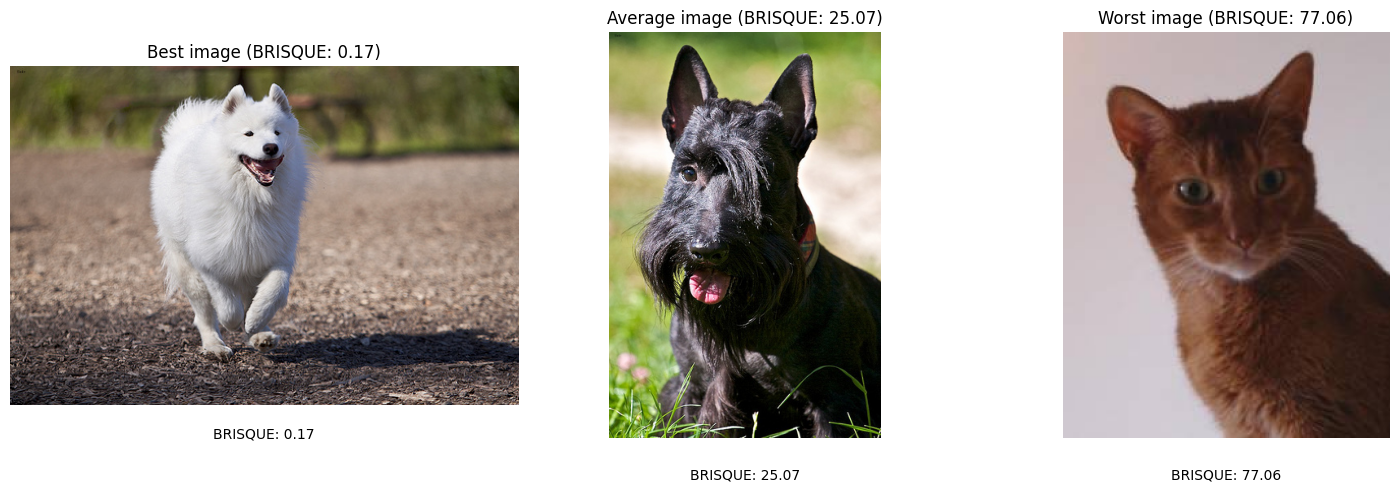

Display improvement process completed.


In [11]:
image_brisque_tuples = list(zip(image_files, brisque_scores))
positive_brisque_images = [(image, score) for image, score in image_brisque_tuples if score > 0]
sorted_images = sorted(positive_brisque_images, key=lambda x: x[1])

if sorted_images:
    # Obtener la mejor, la promedio y la peor imagen
    best_image, best_score = sorted_images[0]
    average_image, average_score = sorted_images[len(sorted_images) // 2]
    worst_image, worst_score = sorted_images[-1]

plt.figure(figsize=(15, 5))

# Mejor imagen
plt.subplot(131)
best_image_path = os.path.join(input_directory, best_image)
best_image = cv2.imread(best_image_path)
plt.imshow(cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB))
plt.title(f"Best image (BRISQUE: {best_score:.2f})")
plt.axis('off')
plt.annotate(f"BRISQUE: {best_score:.2f}", (0.5, -0.1), xycoords="axes fraction", ha="center")

# Imagen promedio
plt.subplot(132)
average_image_path = os.path.join(input_directory, average_image)
average_image = cv2.imread(average_image_path)
plt.imshow(cv2.cvtColor(average_image, cv2.COLOR_BGR2RGB))
plt.title(f"Average image (BRISQUE: {average_score:.2f})")
plt.axis('off')
plt.annotate(f"BRISQUE: {average_score:.2f}", (0.5, -0.1), xycoords="axes fraction", ha="center")

# Peor imagen
plt.subplot(133)
worst_image_path = os.path.join(input_directory, worst_image)
worst_image = cv2.imread(worst_image_path)
plt.imshow(cv2.cvtColor(worst_image, cv2.COLOR_BGR2RGB))
plt.title(f"Worst image (BRISQUE: {worst_score:.2f})")
plt.axis('off')
plt.annotate(f"BRISQUE: {worst_score:.2f}", (0.5, -0.1), xycoords="axes fraction", ha="center")

plt.tight_layout()
plt.show()

print("Display improvement process completed.")

## Problem identification:

In this phase of the project we were able to identify the main characteristics to attack regarding this problem, which are:

- Variability in the quality of the original images.
- The need to improve the visual quality of images for more precise analysis.
- The importance of standardizing the improvement process to guarantee consistent and reliable results.
- The need to quantitatively evaluate the quality of enhanced images.

## Solution Formulation:
To address this problem properly, we have formulated a solution related to the previously mentioned problems:

- Apply a series of image transformations, including saturation enhancement, sharpening and resizing, to improve the quality of the images and their normalization for the next stage of the project.
- We ensure that the enhancement process is consistent and standardized, allowing us to apply it to all images in the data set.
- We use the BRISQUE metric to quantitatively evaluate the quality of the enhanced images and therefore measure the impact of our transformations.
- We randomly select a subset of 50 images from the dataset to perform our evaluation.
- We print the BRISQUE results of our images with and without the transformation pipeline to evaluate our results.
- We show the best image, one that is close to the average, and the worst image to be able to see the results obtained in even more detail.

All of these previously mentioned solutions were implemented in the previous code.

## Solutions Evaluation:
The evaluation of the solutions involves carrying out a logical and exhaustive interpretation of the results obtained:

- Implementation of the selected filter pipeline improved the BRISQUE score by around 6 to 7 points on average. This suggests a significant improvement in the perceived quality of the images after applying the filters. The filters were meticulously selected, indicating careful consideration of the specific characteristics of the data set and the desired results.

- The selected filter pipeline is as follows:
    1. cv2.createCLAHE: This filter performs adaptive local contrast enhancement. Adjusts the contrast of each pixel based on its local environment.

    2. cv2.resize with INTER_NEAREST_EXACT: Performs a resize of the image with the nearest neighbor method. INTER_NEAREST_EXACT ensures that no interpolation is performed during resizing.

    3. bilateralFilter: It is a filter that smoothes the image while preserving the edges. It is particularly useful for reducing noise while preserving important details.

    4. unsharp_mask: This filter enhances fine details and edges of the image. Uses a non-sharp focus to enhance the sharpness of the image.

    5. increase_saturation: Increases the color saturation of the image. It is done in the HSV color space to control the intensity of the change without affecting the luminance.
- Sure, let's dive into why filter order is critical in the image enhancement pipeline:

- The order of filters in the image enhancement pipeline is critical because of how each filter affects the information and details in the image. Here is a more detailed explanation of why the order is critical:

    1. **cv2.createCLAHE (Contrast Limited Adaptive Histogram Equalization)**:
        - This filter improves image contrast by locally adjusting contrast based on local features. This means that it enhances details in areas of the image that have significant intensity differences.
        - It is essential to apply this filter at the beginning of the pipeline, as it prepares the image by enhancing local details. If applied after other filters, it could amplify noise and have an undesirable effect on image quality.

    2. **cv2.resize with INTER_NEAREST_EXACT (Resizing without interpolation)**:
        - This step resizes the image to the desired size without applying interpolation. INTER_NEAREST_EXACT ensures that no pixel smoothing or interpolation is performed.
        - Should be done after cv2.createCLAHE because the improved contrast could result in smaller, finer details in the image. Resizing first will allow you to preserve these essential details.

    3. **bilateralFilter**:
        - The bilateral filter softens the image while preserving important edges and details. It is useful for reducing noise in the image without removing critical information.
        - Should be applied after resizing to smooth out details and reduce noise. If applied before resizing, it could reduce the quality of important details that are enlarged during the resizing process.

    4. **unsharp_mask**:
        - This filter is used to improve sharpness and fine details in the image. Enhances edges and enhances details.
        - It is important to apply this filter after other filters, such as bilateral filter smoothing, to enhance details and edges effectively.

    5. **increase_saturation (Saturation Increase)**:
        - Increasing saturation improves the vibrancy of colors in the image.
        - It should be applied at the end of the pipeline to prevent the other filters from introducing unwanted distortions in the color saturation.

    The order of the filters in the pipeline is based on the principle that each filter performs a specific operation on the image and prepares the image for the next filter. Changing the order could negatively affect image quality by highlighting or softening details at the wrong time in the process. The current order has been carefully selected to achieve effective and consistent image quality improvement.



## Application Resources:
During this stage of the project we constantly apply modern resources, techniques, skills and tools to identify, formulate and solve the problem of improving image quality:

- We use image processing libraries such as OpenCV.
- Implementation of image processing techniques such as saturation enhancement and sharpening.
- Use of the BRISQUE metric as a modern tool for the objective evaluation of image quality.
- Programming application in Python and the Jupyter Notebook environment to develop and document the project effectively.

## References:

[1] OpenCV - Bilateral Filter. (n.d.). Retrieved from https://www.tutorialspoint.com/opencv/opencv_bilateral_filter.htm

[2] Rosebrock, A. (2021). OpenCV Histogram Equalization and Adaptive Histogram Equalization (CLAHE). Retrieved from https://pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/

[3] Shrimali, K. R. (2021). Image Quality Assessment : BRISQUE. Retrieved from https://learnopencv.com/image-quality-assessment-brisque/

[4] Ziskovin, G. (n.d.). Different Interpolation methods in OpenCV. Retrieved from https://iq.opengenus.org/different-interpolation-methods-in-opencv/
